# FashionNet
A simple convolutional neural network that classifies 10 clothing types given a clothing image.

The classes this model classifies are:
1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot


## Notebook Content:

1. Imports and Dependencies.
2. Dataset Loading and Preprocessing.
3. Data Visualization.
4. The Training Routine.
5. Training the Model.
6. Evaluating the Model.
7. Saving and Loading the Model.

In [1]:
%load_ext autoreload
%autoreload 2

# 1. Imports and Dependencies

In [40]:
# Model imports:
from model import FashionNet

# Utility functions imports:
from utils import train, evaluate, predict, load_data

# PyTorch imports:
from torch.optim import AdamW
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch

# NumPy imports:
import numpy as np

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Pandas imports:
import pandas as pd

# Sklearn imports:
from sklearn.metrics import classification_report, confusion_matrix

# Other imports:
import os
import random

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 2. Dataset Loading and Preprocessing

### Preprocessing the data:

In [4]:
# The mean and standard deviation of the dataset for normalization:
mean = [0.286]
std = [0.353]

In [5]:
image_size = (64, 64)

# Data Augmentation transform:
train_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
        T.Resize(image_size),
        T.RandomRotation(20),
        T.RandomHorizontalFlip(p=0.7)
])

# Validation and test sets transform:
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
    T.Resize(image_size)])

### Loading the data:

In [90]:
batch_size = 1024
num_workers = 8

original_set, _, _ = load_data(batch_size=batch_size, num_workers=num_workers,
                                                  train_transform=T.ToTensor(), val_transform=T.ToTensor())

train_set, val_set, test_set = load_data(batch_size=batch_size, num_workers=num_workers,
                                                  train_transform=train_transform, val_transform=val_transform)

print(f'Train set size: {len(train_set)}\n Val set size {len(val_set)}\n Test set size: {len(test_set)}')

Train set size: 60000
 Val set size 6000
 Test set size: 4000


# 3. Data Visualization:

### Train class distribution:

<BarContainer object of 10 artists>

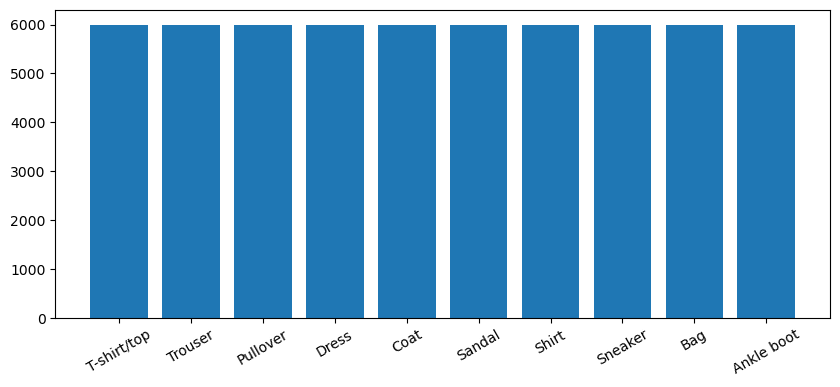

In [7]:
# Getting the class distribution:
class_dist = np.bincount(train_set.targets)

# Plotting the class distribution:
figure(figsize=(10, 4), dpi=100)

plt.xticks(rotation=30)
plt.bar(train_set.classes, class_dist)

## Showing random images from the dataset and comparing how the preprocessed images differ from the original ones:

In [93]:
# Getting random indecies of the images to show:
num_images = 8
random_indecies = np.random.choice(np.arange(len(train_set)), num_images, replace=False)

original_images = []
original_labels = []

images = []
labels = []

for idx in random_indecies:
    # Getting the orignal images:
    o_image, o_label = original_set[idx]
    original_labels.append(o_label)
    
    # Getting the preprocessed images
    image, label = train_set[idx]
    labels.append(label)
    
    # Converting the original image from torch.tensor to a numpy array:
    o_image = np.transpose(o_image.cpu().detach().numpy(), (1, 2, 0))
    original_images.append(o_image)   
    
    # Converting the preprocessed image from torch.tensor to a numpy array:
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    images.append(image)    

In [94]:
# Maps the labels from the int values to the str values:
map_labels = dict(zip(train_set.class_to_idx.values(), train_set.class_to_idx.keys()))

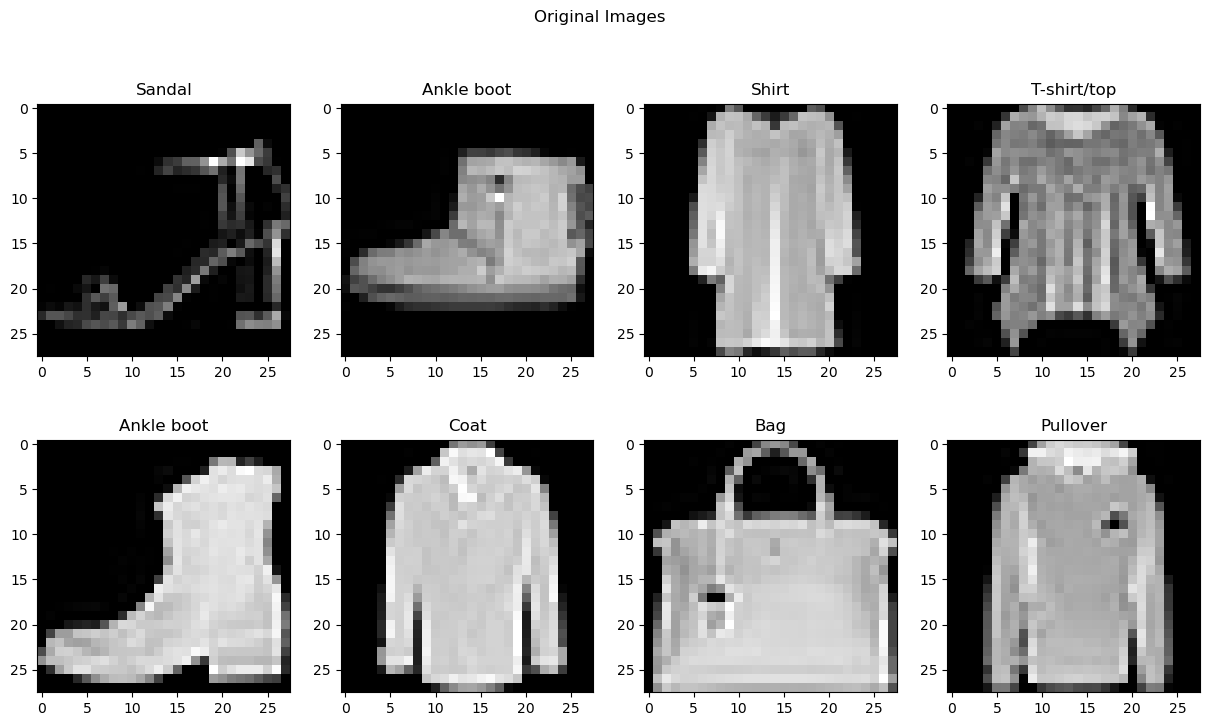

In [101]:
fig, axarr = plt.subplots(2, num_images // 2)

fig_width, fig_height = 15, 8

fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)

fig.suptitle("Original Images")

for image, label, ax in zip(original_images, original_labels, axarr.flatten()):
    txt_label = map_labels[label]
    ax.set_title(txt_label)
    ax.imshow(image, cmap='gray')

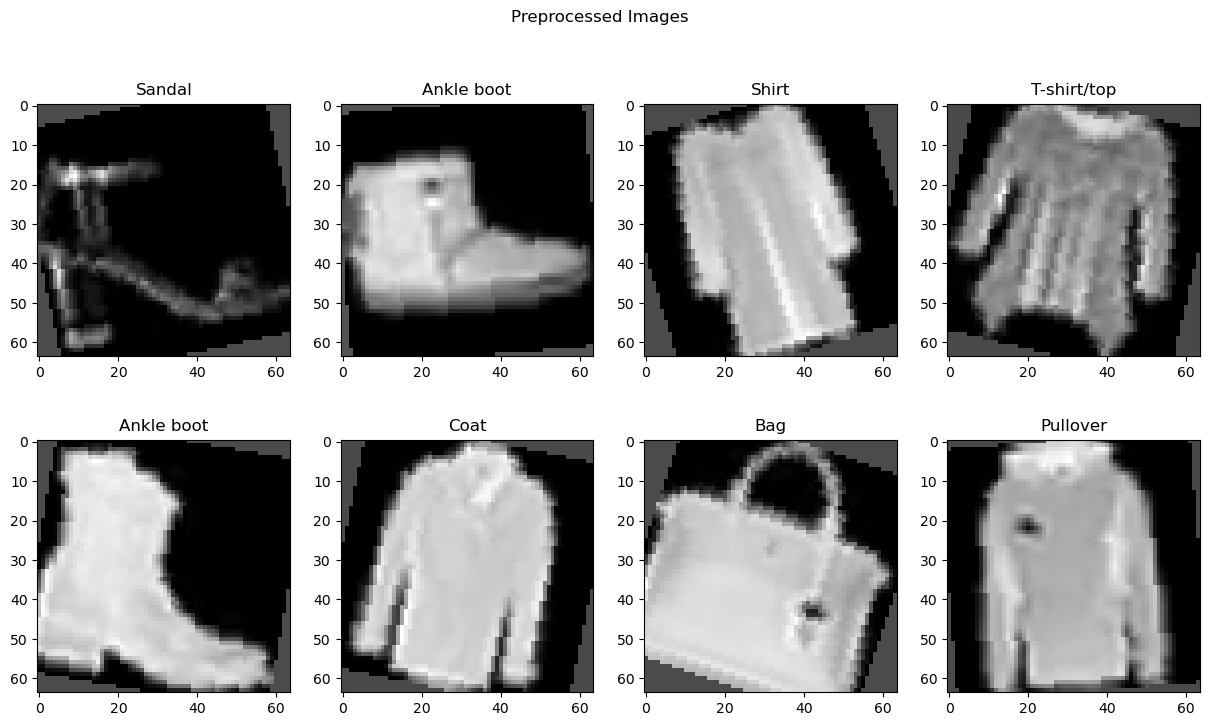

In [99]:
fig, axarr = plt.subplots(2, num_images // 2)

fig_width, fig_height = 15, 8

fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)

fig.suptitle("Preprocessed Images")

for image, label, ax in zip(images, labels, axarr.flatten()):
    txt_label = map_labels[label]
    ax.set_title(txt_label)
    ax.imshow(image, cmap='gray')

# 4. The Training Routine:

### Creating the DataLoader objects:

In [12]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

validation_loader = DataLoader(dataset=val_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

test_loader = DataLoader(dataset=test_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

### Creating the model:

In [13]:
number_of_classes = len(set(train_set.classes))
model = FashionNet(number_of_classes=number_of_classes, image_size=image_size[0])

### The loss function and optimizer:

In [14]:
# --- Loss function: ------------------------------------------
criterion = nn.CrossEntropyLoss()

# --- Optimizer: ----------------------------------------------
learning_rate = 3e-3
weight_decay = 1e-5

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)

# --- Learning rate scheduler: --------------------------------
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)

### Number of epochs:

In [15]:
epochs = 60

# 5. Training the model:

In [16]:
train_params = {'model' : model, 'criterion' : criterion, 'optimizer' : optimizer , 'train_loader' : train_loader,
                'val_loader' : validation_loader, 'epochs' : epochs, 'lr_scheduler' : lr_scheduler,
                'verbose' : True}

In [17]:
total_loss, train_accuracies, val_accuracies, lrs = train(**train_params)

  0%|          | 0/60 [00:00<?, ?it/s]

Evaluating epoch...


  2%|▏         | 1/60 [00:16<15:48, 16.08s/it]

Epoch: 0 | Loss: 204.5220 | Train_acc: 71.30% | Val_acc: 69.43% | LR: 0.003
Evaluating epoch...


  3%|▎         | 2/60 [00:30<14:39, 15.16s/it]

Epoch: 1 | Loss: 86.4891 | Train_acc: 80.80% | Val_acc: 79.93% | LR: 0.003
Evaluating epoch...


  5%|▌         | 3/60 [00:45<14:12, 14.96s/it]

Epoch: 2 | Loss: 42.6176 | Train_acc: 82.04% | Val_acc: 80.52% | LR: 0.003
Evaluating epoch...


  7%|▋         | 4/60 [00:59<13:48, 14.80s/it]

Epoch: 3 | Loss: 35.0074 | Train_acc: 84.44% | Val_acc: 82.18% | LR: 0.003
Evaluating epoch...


  8%|▊         | 5/60 [01:14<13:33, 14.79s/it]

Epoch: 4 | Loss: 29.8728 | Train_acc: 84.92% | Val_acc: 82.48% | LR: 0.003
Evaluating epoch...


 10%|█         | 6/60 [01:29<13:11, 14.66s/it]

Epoch: 5 | Loss: 27.3149 | Train_acc: 86.31% | Val_acc: 83.58% | LR: 0.003
Evaluating epoch...


 12%|█▏        | 7/60 [01:44<13:03, 14.78s/it]

Epoch: 6 | Loss: 25.6542 | Train_acc: 86.37% | Val_acc: 84.57% | LR: 0.003
Evaluating epoch...


 13%|█▎        | 8/60 [01:58<12:46, 14.75s/it]

Epoch: 7 | Loss: 23.7249 | Train_acc: 87.41% | Val_acc: 86.10% | LR: 0.003
Evaluating epoch...


 15%|█▌        | 9/60 [02:13<12:31, 14.73s/it]

Epoch: 8 | Loss: 23.0750 | Train_acc: 87.06% | Val_acc: 85.72% | LR: 0.003
Evaluating epoch...


 17%|█▋        | 10/60 [02:27<12:11, 14.63s/it]

Epoch: 9 | Loss: 22.3186 | Train_acc: 87.94% | Val_acc: 86.22% | LR: 0.003
Evaluating epoch...


 18%|█▊        | 11/60 [02:42<11:54, 14.58s/it]

Epoch: 10 | Loss: 21.2886 | Train_acc: 88.30% | Val_acc: 86.98% | LR: 0.003
Evaluating epoch...


 20%|██        | 12/60 [02:56<11:36, 14.52s/it]

Epoch: 11 | Loss: 20.7938 | Train_acc: 88.28% | Val_acc: 86.42% | LR: 0.003
Evaluating epoch...


 22%|██▏       | 13/60 [03:11<11:21, 14.51s/it]

Epoch: 12 | Loss: 20.2330 | Train_acc: 88.69% | Val_acc: 86.68% | LR: 0.003
Evaluating epoch...


 23%|██▎       | 14/60 [03:25<11:06, 14.49s/it]

Epoch: 13 | Loss: 19.5621 | Train_acc: 89.07% | Val_acc: 87.07% | LR: 0.003
Evaluating epoch...


 25%|██▌       | 15/60 [03:40<10:52, 14.50s/it]

Epoch: 14 | Loss: 18.6842 | Train_acc: 89.39% | Val_acc: 87.50% | LR: 0.003
Evaluating epoch...


 27%|██▋       | 16/60 [03:54<10:35, 14.44s/it]

Epoch: 15 | Loss: 18.3138 | Train_acc: 89.41% | Val_acc: 87.25% | LR: 0.003
Evaluating epoch...


 28%|██▊       | 17/60 [04:09<10:23, 14.50s/it]

Epoch: 16 | Loss: 18.2071 | Train_acc: 89.43% | Val_acc: 87.18% | LR: 0.003
Evaluating epoch...


 30%|███       | 18/60 [04:23<10:05, 14.41s/it]

Epoch: 17 | Loss: 18.1499 | Train_acc: 89.73% | Val_acc: 87.63% | LR: 0.003
Evaluating epoch...


 32%|███▏      | 19/60 [04:37<09:50, 14.40s/it]

Epoch: 18 | Loss: 17.9406 | Train_acc: 89.43% | Val_acc: 87.45% | LR: 0.003
Evaluating epoch...


 33%|███▎      | 20/60 [04:52<09:37, 14.43s/it]

Epoch: 19 | Loss: 17.5276 | Train_acc: 89.57% | Val_acc: 87.85% | LR: 0.003
Evaluating epoch...


 35%|███▌      | 21/60 [05:06<09:23, 14.46s/it]

Epoch: 20 | Loss: 17.4940 | Train_acc: 90.18% | Val_acc: 87.57% | LR: 0.003
Evaluating epoch...


 37%|███▋      | 22/60 [05:21<09:09, 14.47s/it]

Epoch: 21 | Loss: 17.1449 | Train_acc: 89.75% | Val_acc: 86.75% | LR: 0.003
Evaluating epoch...


 38%|███▊      | 23/60 [05:35<08:56, 14.51s/it]

Epoch: 22 | Loss: 16.7225 | Train_acc: 90.24% | Val_acc: 87.95% | LR: 0.003
Evaluating epoch...


 40%|████      | 24/60 [05:50<08:41, 14.49s/it]

Epoch: 23 | Loss: 16.7239 | Train_acc: 90.22% | Val_acc: 88.25% | LR: 0.003
Evaluating epoch...


 42%|████▏     | 25/60 [06:05<08:30, 14.60s/it]

Epoch: 24 | Loss: 16.4415 | Train_acc: 90.23% | Val_acc: 87.22% | LR: 0.00030000000000000003
Evaluating epoch...


 43%|████▎     | 26/60 [06:19<08:13, 14.50s/it]

Epoch: 25 | Loss: 15.0183 | Train_acc: 91.45% | Val_acc: 88.68% | LR: 0.00030000000000000003
Evaluating epoch...


 45%|████▌     | 27/60 [06:34<08:00, 14.56s/it]

Epoch: 26 | Loss: 14.3638 | Train_acc: 91.50% | Val_acc: 88.72% | LR: 0.00030000000000000003
Evaluating epoch...


 47%|████▋     | 28/60 [06:48<07:45, 14.56s/it]

Epoch: 27 | Loss: 14.1947 | Train_acc: 91.61% | Val_acc: 88.57% | LR: 0.00030000000000000003
Evaluating epoch...


 48%|████▊     | 29/60 [07:02<07:29, 14.49s/it]

Epoch: 28 | Loss: 14.1007 | Train_acc: 91.58% | Val_acc: 88.77% | LR: 0.00030000000000000003
Evaluating epoch...


 50%|█████     | 30/60 [07:17<07:15, 14.52s/it]

Epoch: 29 | Loss: 14.0365 | Train_acc: 91.57% | Val_acc: 88.72% | LR: 0.00030000000000000003
Evaluating epoch...


 52%|█████▏    | 31/60 [07:31<06:58, 14.42s/it]

Epoch: 30 | Loss: 13.9230 | Train_acc: 91.57% | Val_acc: 88.78% | LR: 0.00030000000000000003
Evaluating epoch...


 53%|█████▎    | 32/60 [07:45<06:41, 14.35s/it]

Epoch: 31 | Loss: 13.8974 | Train_acc: 91.78% | Val_acc: 89.05% | LR: 0.00030000000000000003
Evaluating epoch...


 55%|█████▌    | 33/60 [08:00<06:27, 14.36s/it]

Epoch: 32 | Loss: 13.7949 | Train_acc: 91.91% | Val_acc: 88.93% | LR: 0.00030000000000000003
Evaluating epoch...


 57%|█████▋    | 34/60 [08:14<06:12, 14.33s/it]

Epoch: 33 | Loss: 13.7951 | Train_acc: 91.69% | Val_acc: 88.87% | LR: 0.00030000000000000003
Evaluating epoch...


 58%|█████▊    | 35/60 [08:28<05:58, 14.35s/it]

Epoch: 34 | Loss: 13.7912 | Train_acc: 91.84% | Val_acc: 89.08% | LR: 0.00030000000000000003
Evaluating epoch...


 60%|██████    | 36/60 [08:43<05:44, 14.37s/it]

Epoch: 35 | Loss: 13.6381 | Train_acc: 91.78% | Val_acc: 89.18% | LR: 0.00030000000000000003
Evaluating epoch...


 62%|██████▏   | 37/60 [08:57<05:31, 14.42s/it]

Epoch: 36 | Loss: 13.6560 | Train_acc: 91.82% | Val_acc: 89.02% | LR: 0.00030000000000000003
Evaluating epoch...


 63%|██████▎   | 38/60 [09:12<05:16, 14.40s/it]

Epoch: 37 | Loss: 13.6282 | Train_acc: 91.84% | Val_acc: 89.07% | LR: 0.00030000000000000003
Evaluating epoch...


 65%|██████▌   | 39/60 [09:26<05:03, 14.47s/it]

Epoch: 38 | Loss: 13.5313 | Train_acc: 92.00% | Val_acc: 89.08% | LR: 0.00030000000000000003
Evaluating epoch...


 67%|██████▋   | 40/60 [09:41<04:49, 14.46s/it]

Epoch: 39 | Loss: 13.5691 | Train_acc: 91.91% | Val_acc: 89.05% | LR: 0.00030000000000000003
Evaluating epoch...


 68%|██████▊   | 41/60 [09:55<04:34, 14.46s/it]

Epoch: 40 | Loss: 13.4820 | Train_acc: 91.91% | Val_acc: 89.15% | LR: 0.00030000000000000003
Evaluating epoch...


 70%|███████   | 42/60 [10:10<04:20, 14.47s/it]

Epoch: 41 | Loss: 13.5118 | Train_acc: 91.92% | Val_acc: 89.15% | LR: 0.00030000000000000003
Evaluating epoch...


 72%|███████▏  | 43/60 [10:24<04:06, 14.51s/it]

Epoch: 42 | Loss: 13.5684 | Train_acc: 92.00% | Val_acc: 89.33% | LR: 0.00030000000000000003
Evaluating epoch...


 73%|███████▎  | 44/60 [10:39<03:51, 14.50s/it]

Epoch: 43 | Loss: 13.4657 | Train_acc: 91.96% | Val_acc: 89.43% | LR: 0.00030000000000000003
Evaluating epoch...


 75%|███████▌  | 45/60 [10:53<03:38, 14.54s/it]

Epoch: 44 | Loss: 13.4367 | Train_acc: 92.02% | Val_acc: 89.17% | LR: 0.00030000000000000003
Evaluating epoch...


 77%|███████▋  | 46/60 [11:08<03:22, 14.46s/it]

Epoch: 45 | Loss: 13.4099 | Train_acc: 92.18% | Val_acc: 89.22% | LR: 0.00030000000000000003
Evaluating epoch...


 78%|███████▊  | 47/60 [11:22<03:08, 14.47s/it]

Epoch: 46 | Loss: 13.3569 | Train_acc: 92.01% | Val_acc: 89.05% | LR: 0.00030000000000000003
Evaluating epoch...


 80%|████████  | 48/60 [11:37<02:53, 14.50s/it]

Epoch: 47 | Loss: 13.3205 | Train_acc: 92.14% | Val_acc: 89.38% | LR: 0.00030000000000000003
Evaluating epoch...


 82%|████████▏ | 49/60 [11:52<02:40, 14.59s/it]

Epoch: 48 | Loss: 13.1908 | Train_acc: 92.12% | Val_acc: 89.30% | LR: 0.00030000000000000003
Evaluating epoch...


 83%|████████▎ | 50/60 [12:06<02:25, 14.53s/it]

Epoch: 49 | Loss: 13.1946 | Train_acc: 92.19% | Val_acc: 89.08% | LR: 3.0000000000000004e-05
Evaluating epoch...


 85%|████████▌ | 51/60 [12:21<02:11, 14.59s/it]

Epoch: 50 | Loss: 13.1181 | Train_acc: 92.06% | Val_acc: 89.25% | LR: 3.0000000000000004e-05
Evaluating epoch...


 87%|████████▋ | 52/60 [12:35<01:56, 14.57s/it]

Epoch: 51 | Loss: 13.0392 | Train_acc: 92.26% | Val_acc: 89.22% | LR: 3.0000000000000004e-05
Evaluating epoch...


 88%|████████▊ | 53/60 [12:50<01:41, 14.52s/it]

Epoch: 52 | Loss: 13.1313 | Train_acc: 92.26% | Val_acc: 89.27% | LR: 3.0000000000000004e-05
Evaluating epoch...


 90%|█████████ | 54/60 [13:04<01:27, 14.58s/it]

Epoch: 53 | Loss: 12.9754 | Train_acc: 92.11% | Val_acc: 89.27% | LR: 3.0000000000000004e-05
Evaluating epoch...


 92%|█████████▏| 55/60 [13:19<01:12, 14.57s/it]

Epoch: 54 | Loss: 13.1519 | Train_acc: 92.20% | Val_acc: 89.25% | LR: 3.0000000000000004e-05
Evaluating epoch...


 93%|█████████▎| 56/60 [13:33<00:58, 14.52s/it]

Epoch: 55 | Loss: 13.0661 | Train_acc: 92.27% | Val_acc: 89.45% | LR: 3.0000000000000004e-05
Evaluating epoch...


 95%|█████████▌| 57/60 [13:48<00:43, 14.49s/it]

Epoch: 56 | Loss: 13.1461 | Train_acc: 92.15% | Val_acc: 89.27% | LR: 3.0000000000000004e-05
Evaluating epoch...


 97%|█████████▋| 58/60 [14:02<00:28, 14.46s/it]

Epoch: 57 | Loss: 13.0520 | Train_acc: 92.29% | Val_acc: 89.30% | LR: 3.0000000000000004e-05
Evaluating epoch...


 98%|█████████▊| 59/60 [14:17<00:14, 14.44s/it]

Epoch: 58 | Loss: 13.0610 | Train_acc: 92.10% | Val_acc: 89.42% | LR: 3.0000000000000004e-05
Evaluating epoch...


100%|██████████| 60/60 [14:31<00:00, 14.52s/it]

Epoch: 59 | Loss: 12.9791 | Train_acc: 92.22% | Val_acc: 89.35% | LR: 3.0000000000000004e-05


### Plotting the loss

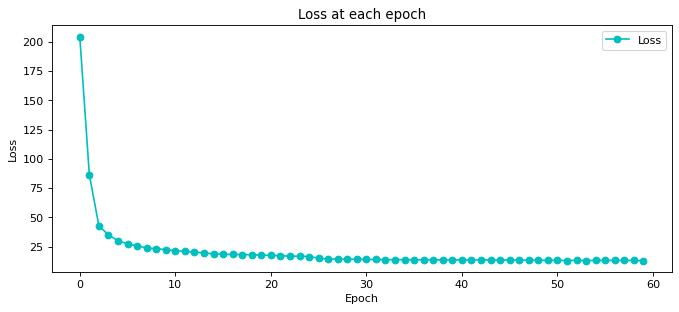

In [18]:
figure(figsize=(10, 4), dpi=80)

plt.title('Loss at each epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(total_loss, 'co-', label='Loss')
plt.legend(loc='upper right')

plt.show()

### Plotting train and validation accuracies:

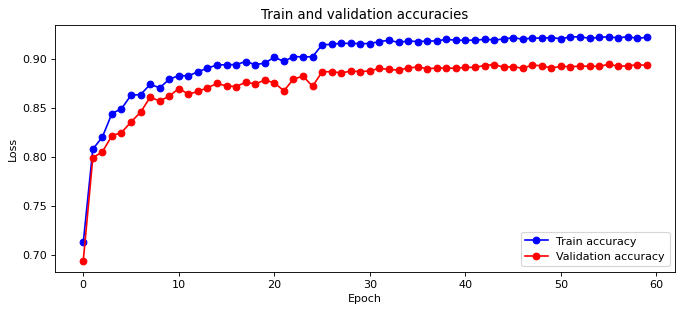

In [19]:
figure(figsize=(10, 4), dpi=80)

plt.title('Train and validation accuracies')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(train_accuracies, 'bo-', label='Train accuracy')
plt.plot(val_accuracies, 'ro-', label='Validation accuracy')

plt.legend(loc='lower right')

plt.show()

## Visualizing the filters:

In this part a random image in convolved with all the convolutional filters. This helps visualize how the model is making the decision of classifiying an image. i.e., what parts of a given image contribute the most to making the classification.

In [83]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Getting a random image from the test set:

In [84]:
rand_index = random.randint(0, len(test_set))
rand_image = test_set[rand_index][0].to(device)

### Getting the first set of filters (1st convolution)

In [85]:
filters_1 = model.conv_1.weight.data.clone()
filter_num_1 = model.conv_1.out_channels

### Plotting the random image convolved with the first filter:

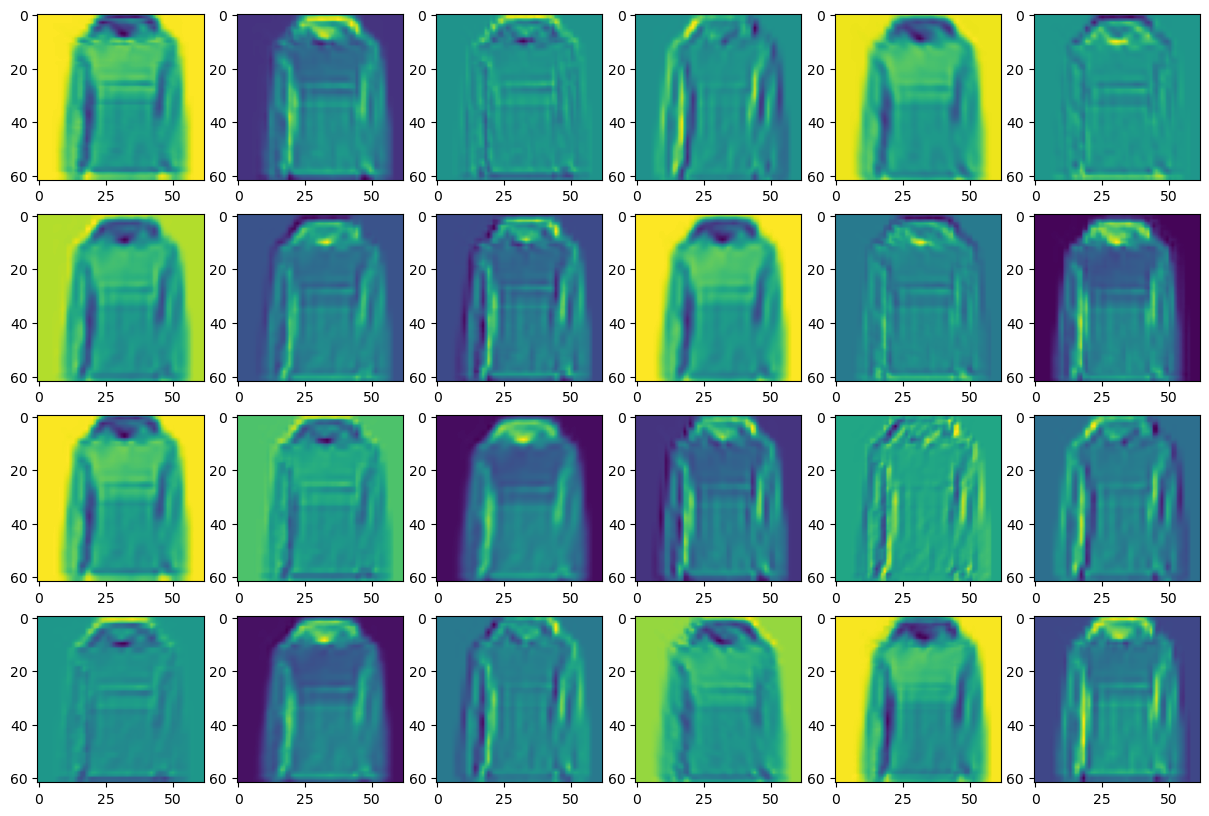

In [86]:
fig, axarr = plt.subplots(4, filter_num_1 // 4)

fig_width, fig_height = 15, 10

fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)

conved_image_1 = torch.nn.functional.conv2d(rand_image, filters_1).cpu().detach().numpy()


for i, ax in enumerate(axarr.flatten()):
    conved_im = conved_image_1[i, :, :]
    ax.imshow(conved_im)

In [87]:
filters_2 = model.conv_2.weight.data.clone()
filter_num_2 = model.conv_2.out_channels

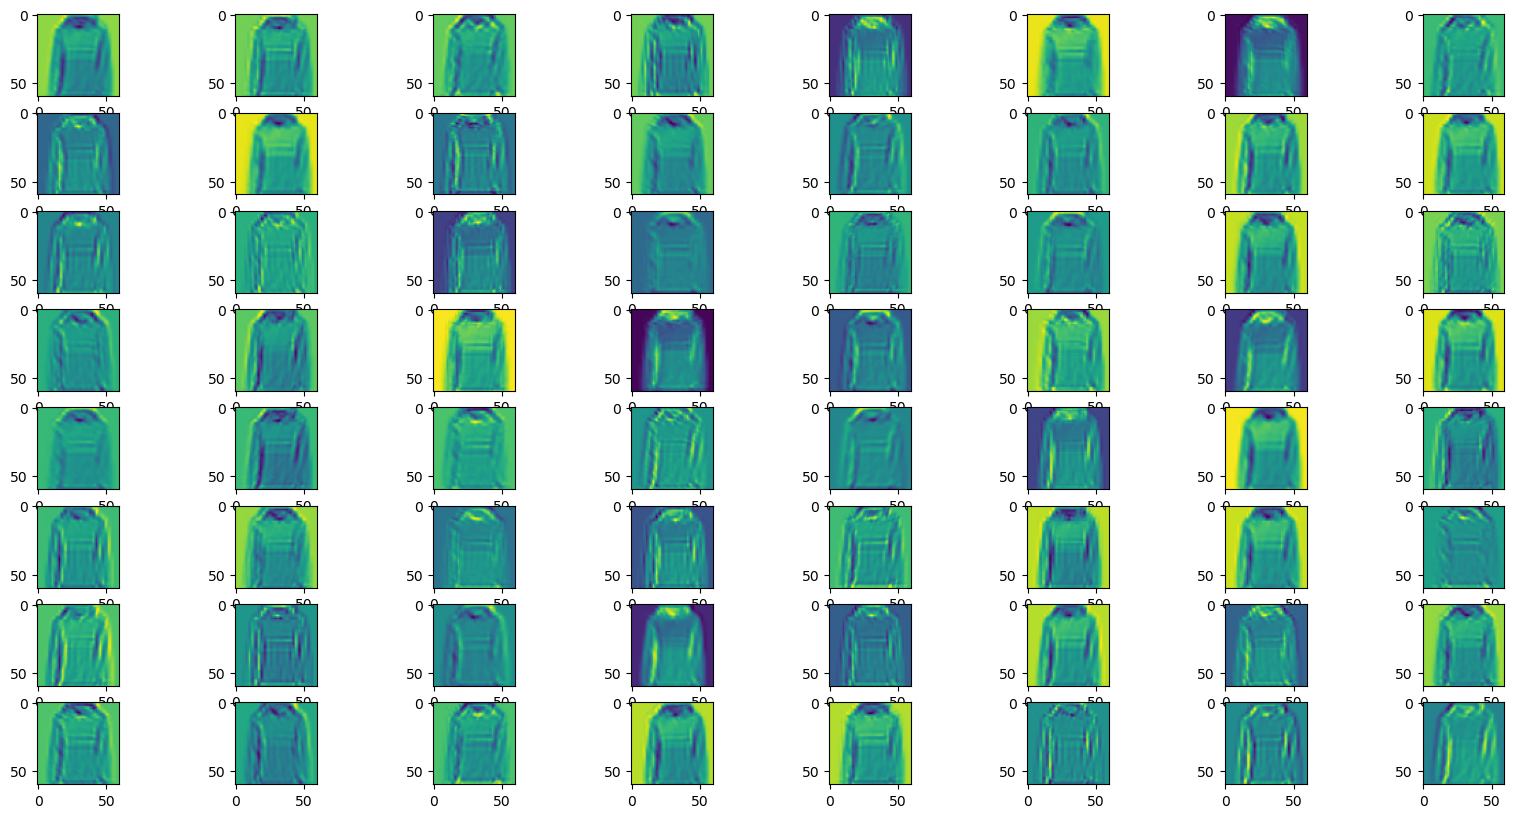

In [88]:
fig, axarr = plt.subplots(8, filter_num_2 // 8)

fig_width, fig_height = 20, 10

fig.set_figwidth(fig_width)
fig.set_figheight(fig_height)

conved_image_1 = torch.tensor(conved_image_1).to(device)
conved_image_2 = torch.nn.functional.conv2d(conved_image_1, filters_2).cpu().detach().numpy()

for i, ax in enumerate(axarr.flatten()):
    conved_im_2 = conved_image_2[i, :, :]
    ax.imshow(conved_im_2)

# 6. Evaluating the model:

### With the accuracy metric:

In [20]:
test_accuracy = evaluate(model, test_loader)

In [21]:
print(f'Accuracy with the test data: {100 * test_accuracy:.2f}%')

Accuracy with the test data: 90.30%


### Evaluating the model with the following metrics:

* Precision
* Recall
* F1-score

In [22]:
# Generating predictions from the test set:
y_pred = predict(model, test_loader)

In [23]:
targets = []

for _, y in test_set:
    targets.append(y)

In [24]:
# Creating the classification report:
cl_report = classification_report(targets, y_pred)
print(cl_report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       408
           1       0.99      0.97      0.98       395
           2       0.86      0.87      0.87       383
           3       0.91      0.92      0.91       386
           4       0.84      0.88      0.86       402
           5       0.98      0.96      0.97       408
           6       0.76      0.70      0.73       406
           7       0.92      0.94      0.93       389
           8       0.98      0.98      0.98       391
           9       0.94      0.93      0.94       432

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



In [25]:
# List of unique classes:
index = list(set(train_set.classes))

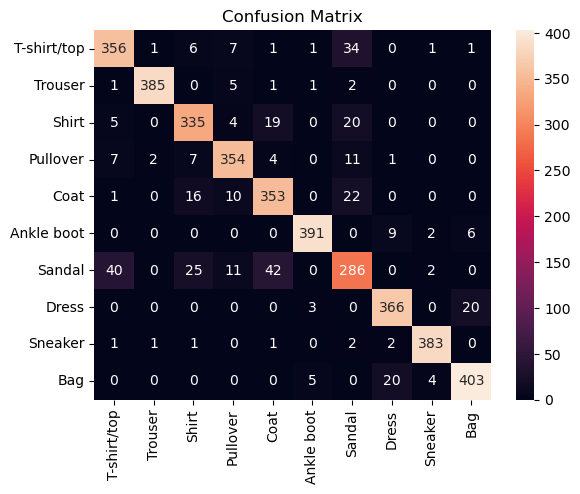

In [26]:
# Getting the confusion matrix:
conf_matrix = confusion_matrix(y_true=targets, y_pred=y_pred)

# Converting the confusion matrix into a pd.DataFrame:
confusion_matrix_df = pd.DataFrame(conf_matrix, columns=index, index=index)

# Plotting the confusion matrix as a heatmap:
sns.heatmap(confusion_matrix_df, annot=True, fmt='d')
plt.title('Confusion Matrix')

plt.show()

# 7. Saving and Loading the Model:

### Saving the model:

In [29]:
model_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'fashion_trained_model')

In [30]:
torch.save(model.state_dict(), model_path)

### Loading the model:

In [31]:
loaded_model = FashionNet(number_of_classes=number_of_classes, image_size=image_size[0])

In [32]:
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>